In [80]:
import os
import gc
import optuna
import numpy as np
from utils import *
import pandas as pd
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score
%run skills.ipynb
%run languages.ipynb
%run work_experiences.ipynb
%run education.ipynb

class config:
    path = '../../../datasets/garanti-bbva-data-camp/'
    sub_path = '../../../datasets/garanti-bbva-data-camp/submission.csv'
    skills_path = '../../../datasets/garanti-bbva-data-camp/skills.csv'
    languages_path = '../../../datasets/garanti-bbva-data-camp/languages.csv'
    education_path = '../../../datasets/garanti-bbva-data-camp/education.csv'
    exp_path = '../../../datasets/garanti-bbva-data-camp/work_experiences.csv'
    seed = 42
    n_folds = 6

In [81]:
train_df = pd.read_csv(os.path.join(config.path, 'train_users.csv'))
test_df = pd.read_csv(os.path.join(config.path, 'test_users.csv'))
sub = pd.read_csv(config.sub_path)

print(f'train_df shape: {train_df.shape}')
print(f'test_df shape: {test_df.shape}')

train_df shape: (53019, 4)
test_df shape: (13255, 3)


In [82]:
df = train_df.append(test_df).reset_index(drop = True)

df.head()

,user_id,industry,location,moved_after_2019
0,1301,Information Technology and Services,"Istanbul, Istanbul, Turkey",1.0
1,6950,Internet,"Istanbul, Istanbul, Turkey",0.0
2,4880,Online Media,Turkey,0.0
3,26046,Telecommunications,"Istanbul, Istanbul, Turkey",0.0
4,11005,Banking,"Istanbul, Turkey",0.0


In [83]:
#df.loc[df['location'].astype(str).str.contains('Afyon')]

In [84]:
def fix_location(dataframe: pd.DataFrame) -> pd.DataFrame:

    df_ = dataframe.copy()
    df_.loc[df_['location'].astype(str).str.contains('Kahraman Maras'), 'location'] = 'Kahramanmaras, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('Şanliurfa'), 'location'] = 'Sanliurfa, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('İçel'), 'location'] = 'Mersin, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('Afyon'), 'location'] = 'Afyonkarahisar, Turkey'
    df_['location'] = df_['location'].apply(lambda x: str(x).replace('Türkiye', 'Turkey'))
    df_['location'] = df_['location'].apply(lambda x: x.upper().strip())
    df_['location'] = df_['location'].apply(lambda x: translation(str(x)))
    tr_cities = load_tr_cities()
    for city in tr_cities:
        df_['location'] = df_['location'].apply(lambda x: city if city in x else x)
        df_['based_on_tr'] = df_['location'].apply(lambda x: 1 if x in tr_cities or x == 'TURKEY' else 0)

    return df_

In [85]:
df = fix_location(df)

skills_df = load_skills(config.skills_path, 30)
lang_df = load_languages(config.languages_path)
#edu_df = load_education(config.education_path, 12)
edu_df = load_education(config.education_path, 12)
exp_df = load_work_experiences(config.exp_path)

df = df.merge(skills_df, on = ['user_id'], how = 'left')
df = df.merge(lang_df, on = ['user_id'], how = 'left')
df = df.merge(edu_df, on = ['user_id'], how = 'left')
df = df.merge(exp_df, on = ['user_id'], how = 'left')

print(df.shape)
df.head()

Frequency of top 20 skills before preprocess: 294433
Frequency of top 20 skills after preprocess: 318624


100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


(66274, 78)


,user_id,industry,location,moved_after_2019,based_on_tr,skill_Java,skill_JavaScript,skill_SQL,skill_C#,skill_Software Development,...,degree_Master of Science,degree_Associate's degree,degree_Bachelor of Engineering,degree_Doctor of Philosophy,degree_Master of Business Administration,degree_Mühendislik Fakültesi Mezunu,total_experience,last_experience,unique_company,avg_days_to_quit
0,1301,Information Technology and Services,ISTANBUL,1.0,1,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1341.0,306.0,3.0,447.000000
1,6950,Internet,ISTANBUL,0.0,1,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2101.0,699.0,4.0,525.250000
2,4880,Online Media,TURKEY,0.0,1,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1826.0,610.0,4.0,456.500000
3,26046,Telecommunications,ISTANBUL,0.0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3409.0,1553.0,1.0,3409.000000
4,11005,Banking,ISTANBUL,0.0,1,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3409.0,640.0,3.0,1136.333333


In [86]:
target = 'moved_after_2019'
cat_features = ['industry', 'location']
drop_features = ['user_id']

for caterogical_col in cat_features:
    df[caterogical_col] = df[caterogical_col].astype(str).astype("category")

train_set = df.loc[df[target].notnull()].drop(columns=drop_features, axis = 1)
test_set = df.loc[df[target].isnull()].drop(columns=drop_features, axis = 1)

print(f'train_set: {train_set.shape}')
print(f'test_set: {test_set.shape}')

train_set: (53019, 77)
test_set: (13255, 77)


In [87]:
# CatBoost Parameters
params = {'one_hot_max_size': 179, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}

params['verbose'] = False
params['random_state'] = config.seed
params['cat_features'] = cat_features
params['eval_metric'] = 'Accuracy'
params['allow_writing_files'] = False
params["iterations"] = 5000

## XGB Parameters
#params = {'max_depth': 10,
#          'subsample': 0.8,
#          'eta': 0.02,
#          'reg_alpha': 2,
#          'reg_lambda': 24,
#          'learning_rate': 0.01}
#
##params['eval_metric'] = 'Accuracy'
#params['random_state'] = config.seed
#params['tree_method'] = 'hist'
#params['n_estimators'] = 5000
#params['enable_categorical'] = True

kf = KFold(n_splits=config.n_folds)


In [88]:
X = train_set.drop(columns=[target], axis=1)
y = train_set[target]
features = X.columns

X_test = test_set.drop(columns=[target], axis=1)
y_oof = np.zeros(X.shape[0])
y_pred = np.zeros(X_test.shape[0])

-----------------------------------| Fold 1 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6409850	test: 0.6384520	best: 0.6384520 (0)	total: 389ms	remaining: 32m 25s
200:	learn: 0.8427867	test: 0.7268304	best: 0.7270567 (198)	total: 13.4s	remaining: 5m 19s
400:	learn: 0.8939387	test: 0.7451624	best: 0.7451624 (400)	total: 27.2s	remaining: 5m 12s
600:	learn: 0.9205559	test: 0.7562521	best: 0.7567048 (596)	total: 41s	remaining: 5m
800:	learn: 0.9397719	test: 0.7633812	best: 0.7633812 (792)	total: 54.6s	remaining: 4m 46s
1000:	learn: 0.9542800	test: 0.7663234	best: 0.7663234 (1000)	total: 1m 7s	remaining: 4m 31s
1200:	learn: 0.9635825	test: 0.7657576	best: 0.7668892 (1086)	total: 1m 21s	remaining: 4m 17s
1400:	learn: 0.9698746	test: 0.7673419	best: 0.7676813 (1391)	total: 1m 34s	remaining: 4m 3s
1600:	learn: 0.9757594	test: 0.7673419	best: 0.7691524 (1502)	total: 1m 48s	remaining: 3m 49s
1800:	learn: 0.9801729	test: 0.7667761	best: 0.7694919 (1631)	total: 

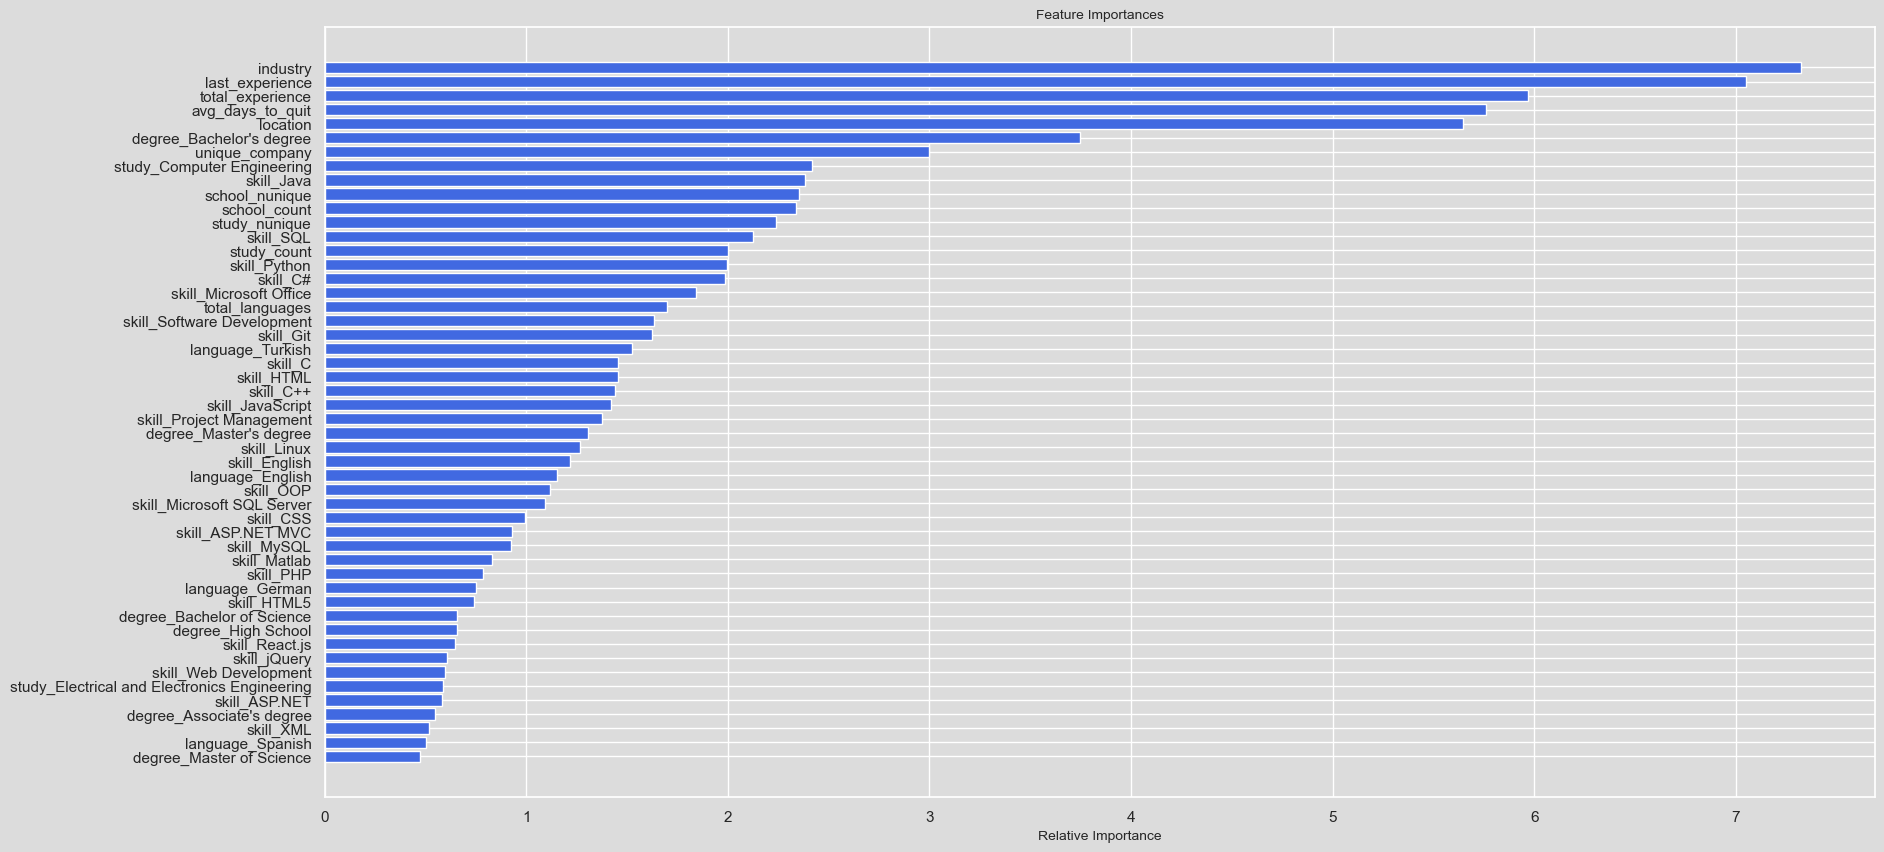

fold accuracy: 0.7694919090188979
-----------------------------------| Fold 2 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6626002	test: 0.6447890	best: 0.6447890 (0)	total: 152ms	remaining: 12m 38s
200:	learn: 0.8432393	test: 0.7288673	best: 0.7290936 (198)	total: 12.9s	remaining: 5m 7s
400:	learn: 0.8943235	test: 0.7509336	best: 0.7510467 (398)	total: 26.2s	remaining: 5m
600:	learn: 0.9249921	test: 0.7582890	best: 0.7587417 (559)	total: 39.5s	remaining: 4m 49s
800:	learn: 0.9430085	test: 0.7605522	best: 0.7620233 (701)	total: 52.9s	remaining: 4m 37s
1000:	learn: 0.9561133	test: 0.7640602	best: 0.7649655 (957)	total: 1m 6s	remaining: 4m 24s
1200:	learn: 0.9657779	test: 0.7668892	best: 0.7673419 (1197)	total: 1m 19s	remaining: 4m 11s
1400:	learn: 0.9730660	test: 0.7674550	best: 0.7686998 (1380)	total: 1m 32s	remaining: 3m 58s
1600:	learn: 0.9784301	test: 0.7703972	best: 0.7707367 (1597)	total: 1m 46s	remaining: 3m 45s
1800:	learn: 0.9823458	test: 0.769

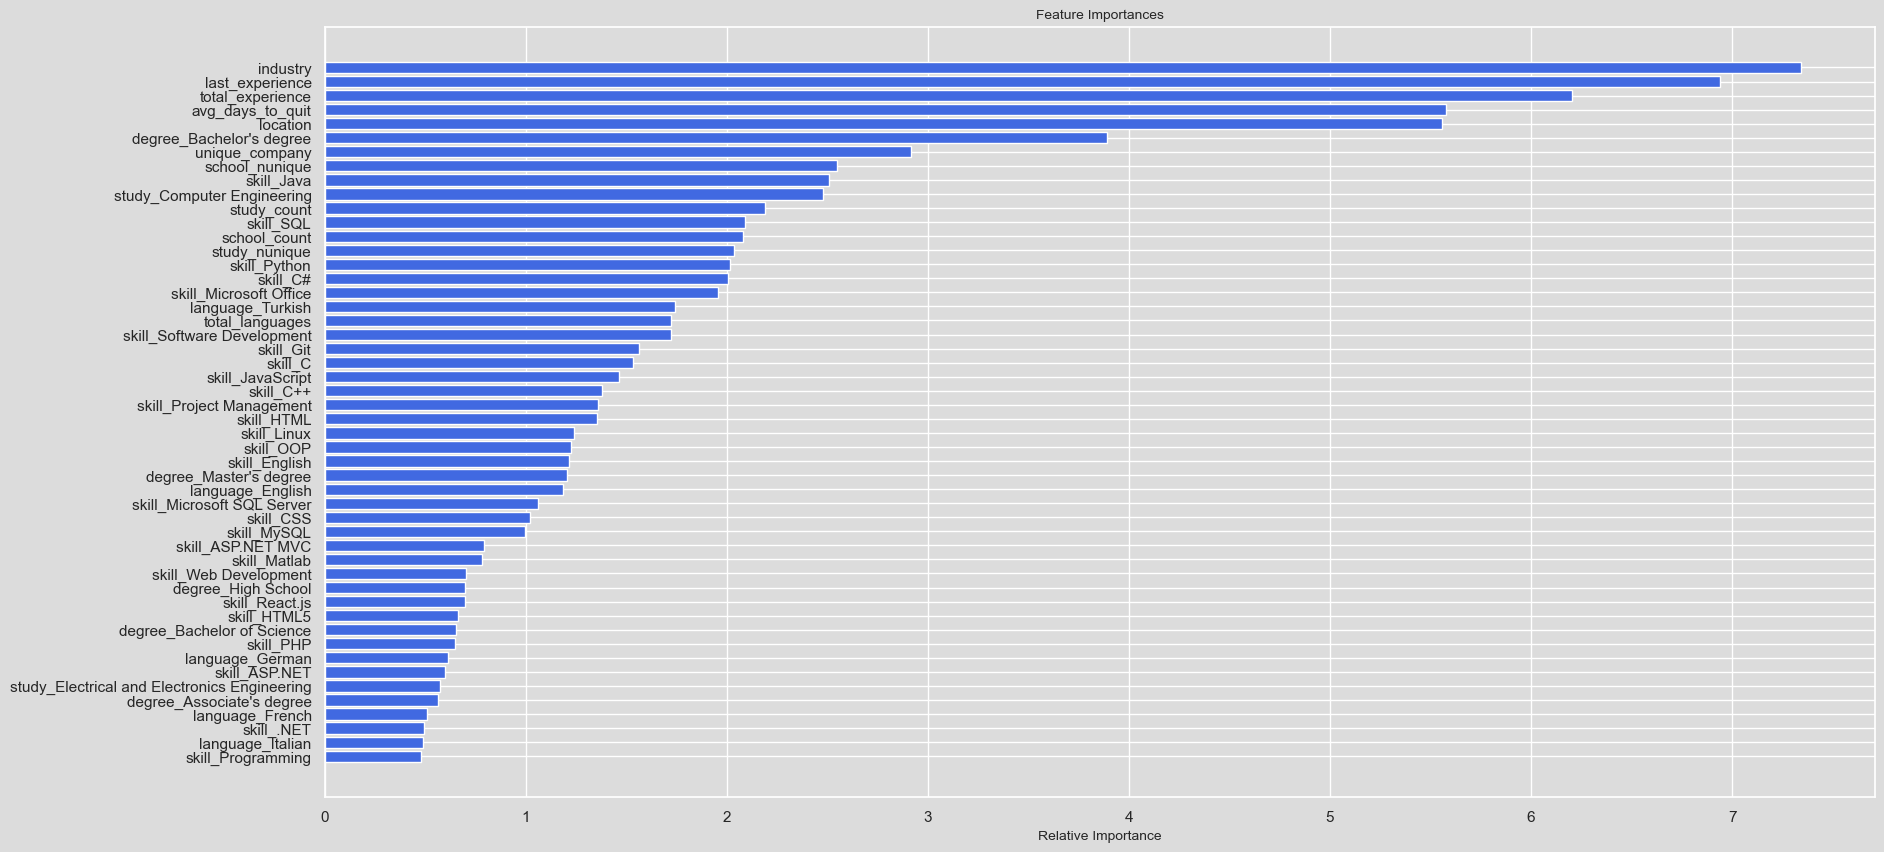

fold accuracy: 0.7720946022405794
-----------------------------------| Fold 3 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6774026	test: 0.6445626	best: 0.6445626 (0)	total: 169ms	remaining: 14m 7s
200:	learn: 0.8455027	test: 0.7292067	best: 0.7292067 (200)	total: 13.2s	remaining: 5m 16s
400:	learn: 0.8950251	test: 0.7451624	best: 0.7455019 (386)	total: 26.5s	remaining: 5m 3s
600:	learn: 0.9253316	test: 0.7548942	best: 0.7567048 (546)	total: 39.9s	remaining: 4m 52s
800:	learn: 0.9433027	test: 0.7600996	best: 0.7605522 (796)	total: 53.5s	remaining: 4m 40s
1000:	learn: 0.9563171	test: 0.7663234	best: 0.7663234 (1000)	total: 1m 6s	remaining: 4m 27s
1200:	learn: 0.9658232	test: 0.7676813	best: 0.7682471 (1052)	total: 1m 20s	remaining: 4m 13s
1400:	learn: 0.9727491	test: 0.7717551	best: 0.7723209 (1398)	total: 1m 33s	remaining: 4m
1600:	learn: 0.9777738	test: 0.7734525	best: 0.7739052 (1588)	total: 1m 47s	remaining: 3m 47s
1800:	learn: 0.9821420	test: 0.774

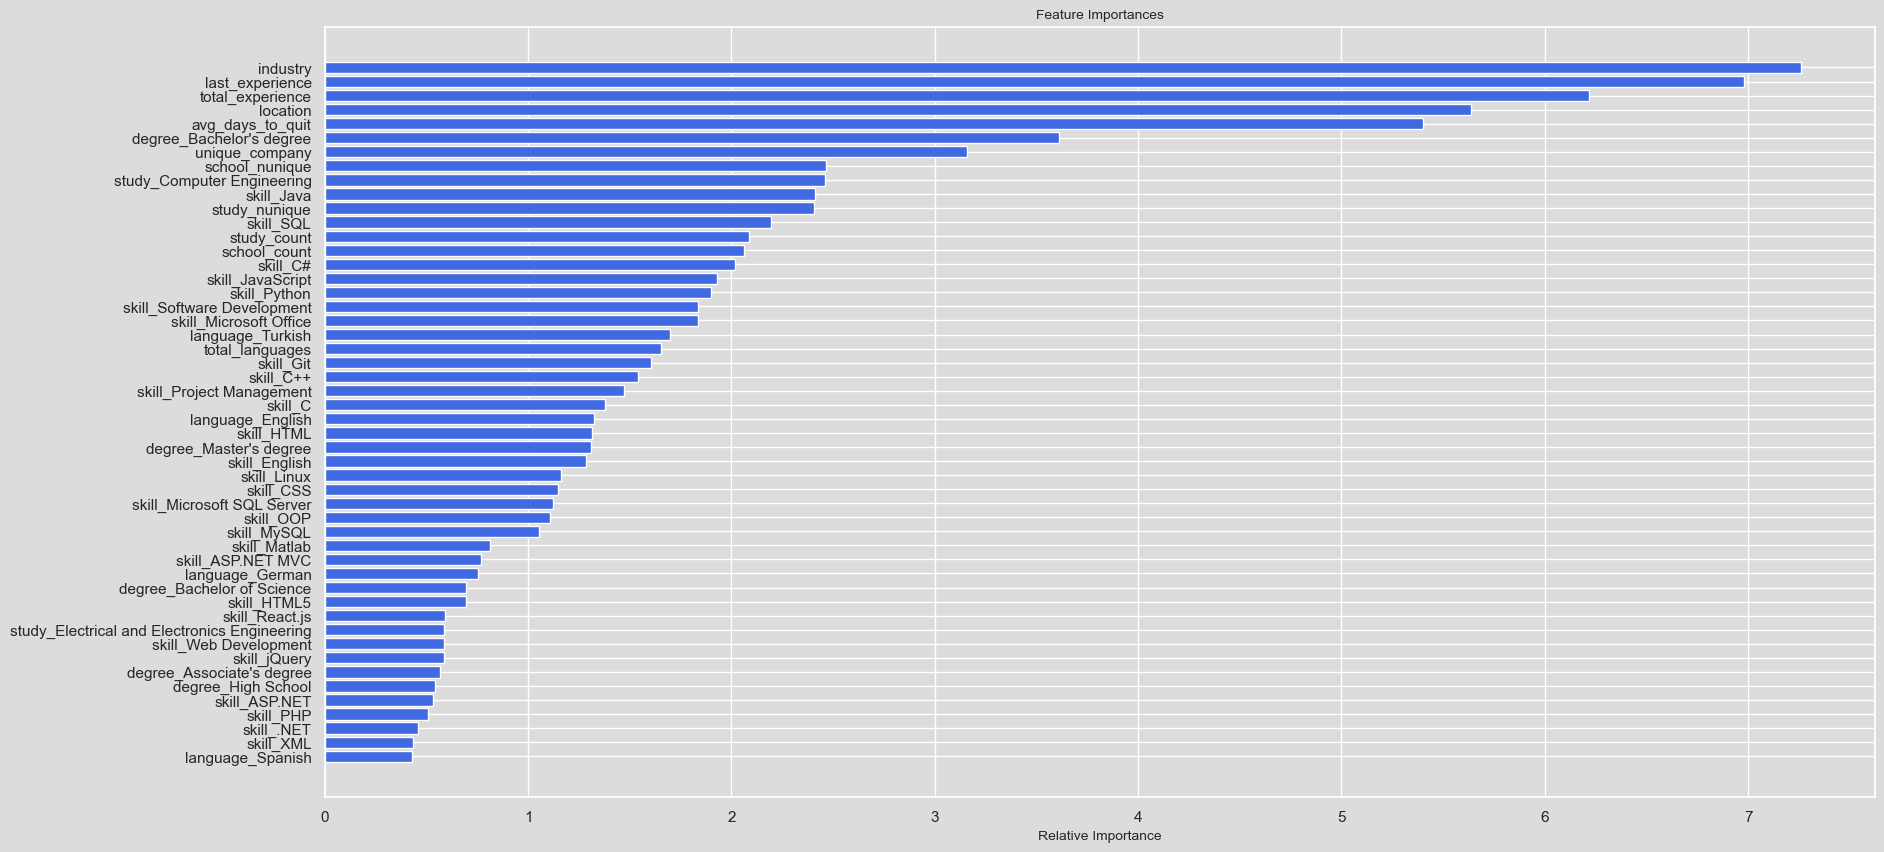

fold accuracy: 0.7751499377616838
-----------------------------------| Fold 4 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6565195	test: 0.6355817	best: 0.6355817 (0)	total: 111ms	remaining: 9m 16s
200:	learn: 0.8429486	test: 0.7252150	best: 0.7254414 (199)	total: 12.9s	remaining: 5m 8s
400:	learn: 0.8931263	test: 0.7427569	best: 0.7436623 (392)	total: 26s	remaining: 4m 58s
600:	learn: 0.9227757	test: 0.7510186	best: 0.7510186 (592)	total: 39.3s	remaining: 4m 47s
800:	learn: 0.9416970	test: 0.7596197	best: 0.7601856 (795)	total: 52.6s	remaining: 4m 35s
1000:	learn: 0.9543263	test: 0.7622227	best: 0.7626754 (982)	total: 1m 6s	remaining: 4m 24s
1200:	learn: 0.9636285	test: 0.7648257	best: 0.7650521 (1197)	total: 1m 19s	remaining: 4m 11s
1400:	learn: 0.9714370	test: 0.7656179	best: 0.7661838 (1390)	total: 1m 32s	remaining: 3m 58s
1600:	learn: 0.9770274	test: 0.7651652	best: 0.7672024 (1425)	total: 1m 45s	remaining: 3m 44s
1800:	learn: 0.9813050	test: 0.76

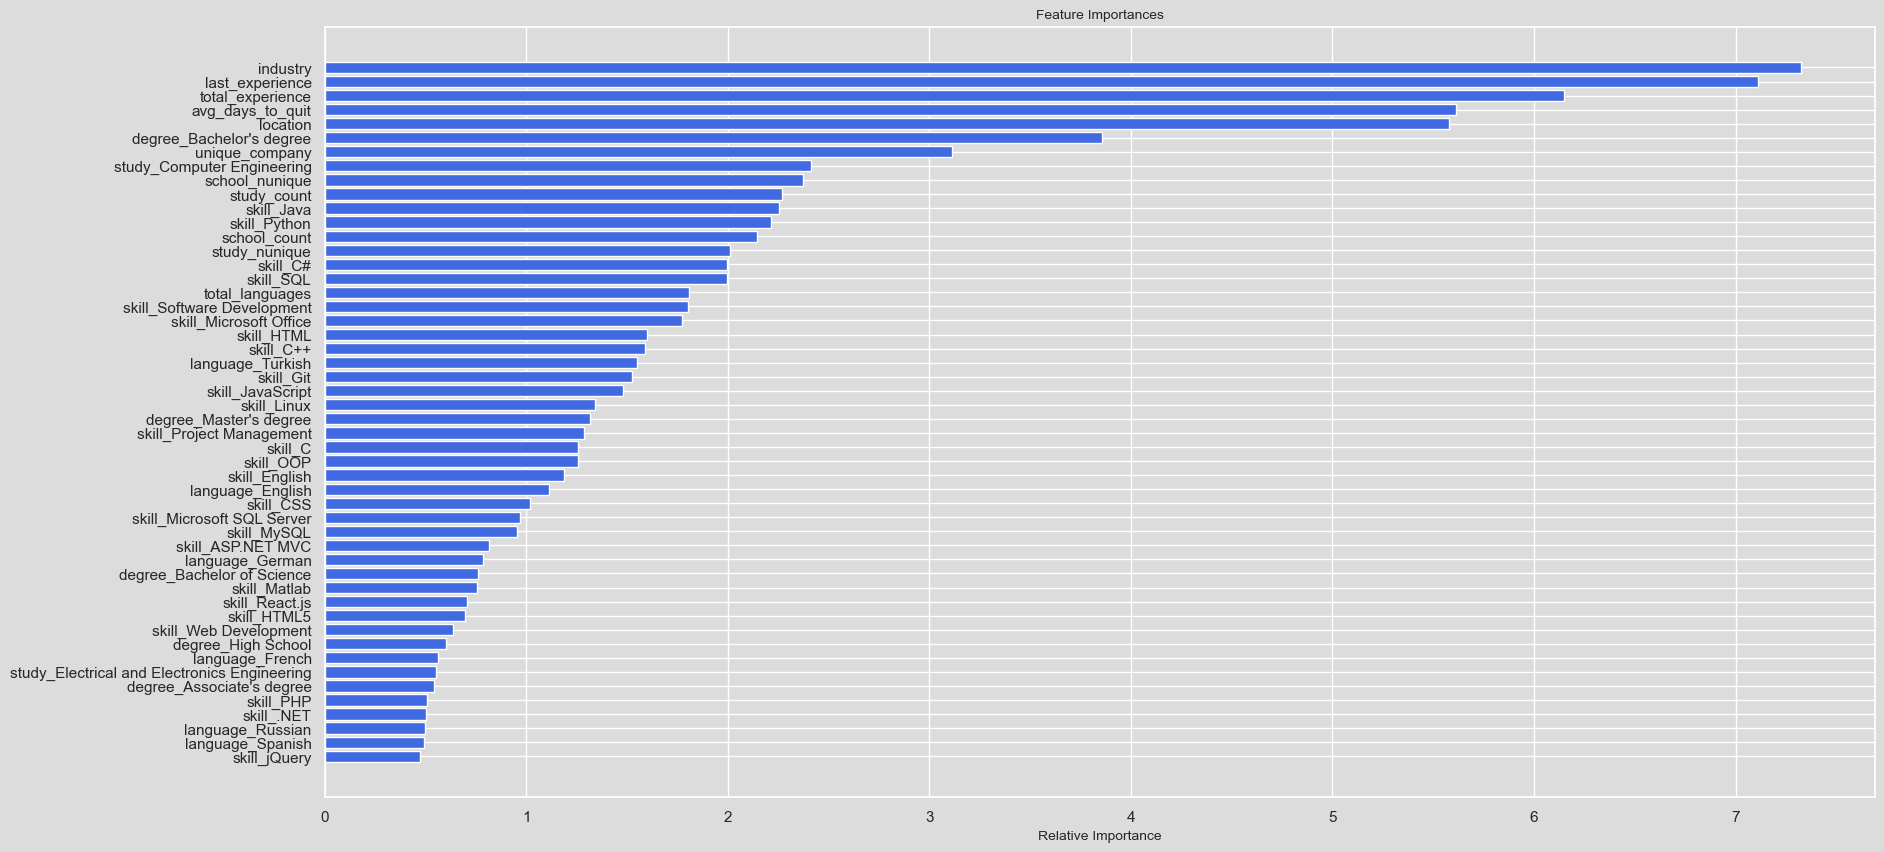

fold accuracy: 0.7672023540063377
-----------------------------------| Fold 5 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6621099	test: 0.6407877	best: 0.6407877 (0)	total: 141ms	remaining: 11m 45s
200:	learn: 0.8442387	test: 0.7330240	best: 0.7338162 (196)	total: 17.9s	remaining: 7m 6s
400:	learn: 0.8941222	test: 0.7476234	best: 0.7478497 (399)	total: 35.9s	remaining: 6m 51s
600:	learn: 0.9244958	test: 0.7580353	best: 0.7593934 (596)	total: 54.4s	remaining: 6m 38s
800:	learn: 0.9426703	test: 0.7610910	best: 0.7624491 (794)	total: 1m 12s	remaining: 6m 18s
1000:	learn: 0.9568386	test: 0.7648257	best: 0.7674287 (912)	total: 1m 30s	remaining: 6m 2s
1200:	learn: 0.9662314	test: 0.7679946	best: 0.7696922 (1175)	total: 1m 48s	remaining: 5m 44s
1400:	learn: 0.9728855	test: 0.7699185	best: 0.7699185 (1400)	total: 2m 7s	remaining: 5m 26s
1600:	learn: 0.9787248	test: 0.7694658	best: 0.7704844 (1541)	total: 2m 25s	remaining: 5m 8s
1800:	learn: 0.9821651	test: 0.

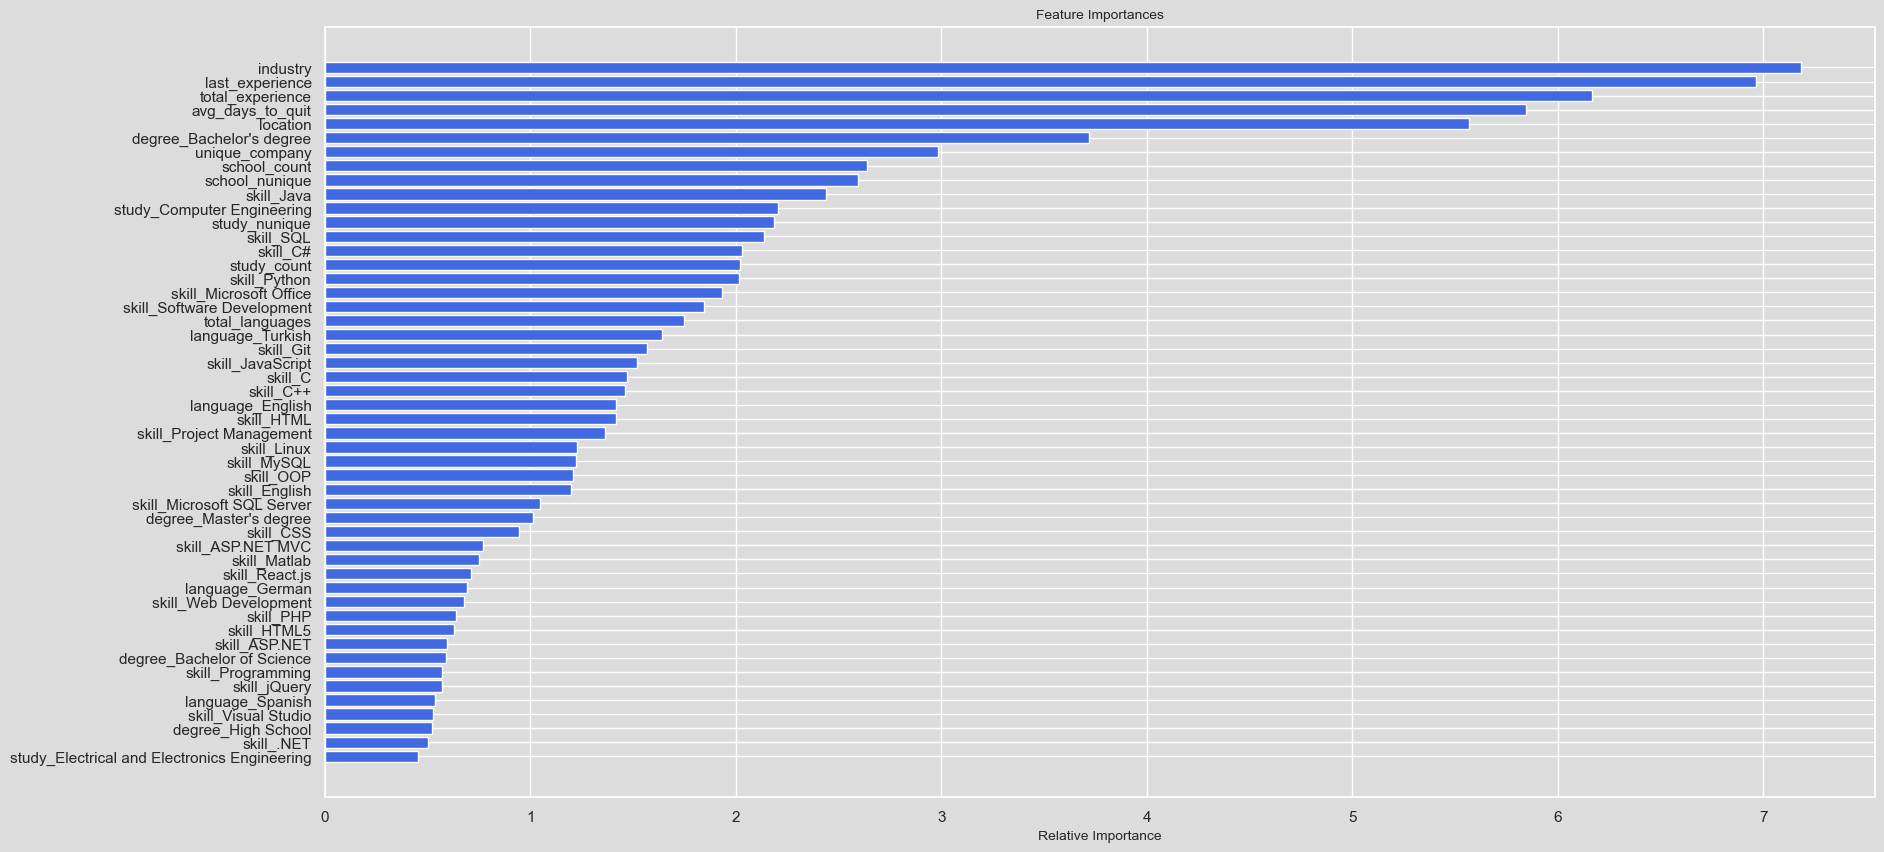

fold accuracy: 0.7717292892711635
-----------------------------------| Fold 6 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6557273	test: 0.6281123	best: 0.6281123 (0)	total: 72.2ms	remaining: 6m 1s
200:	learn: 0.8450535	test: 0.7273653	best: 0.7277048 (196)	total: 13.2s	remaining: 5m 15s
400:	learn: 0.8919268	test: 0.7454731	best: 0.7463785 (397)	total: 26.2s	remaining: 5m
600:	learn: 0.9214404	test: 0.7518108	best: 0.7522635 (597)	total: 39.5s	remaining: 4m 48s
800:	learn: 0.9415839	test: 0.7550928	best: 0.7557718 (784)	total: 52.8s	remaining: 4m 36s
1000:	learn: 0.9539416	test: 0.7587144	best: 0.7596197 (966)	total: 1m 5s	remaining: 4m 23s
1200:	learn: 0.9636285	test: 0.7613173	best: 0.7616569 (1192)	total: 1m 19s	remaining: 4m 10s
1400:	learn: 0.9712559	test: 0.7625622	best: 0.7633545 (1323)	total: 1m 32s	remaining: 3m 57s
1600:	learn: 0.9758957	test: 0.7609778	best: 0.7633545 (1323)	total: 1m 45s	remaining: 3m 44s
Stopped by overfitting detector  (

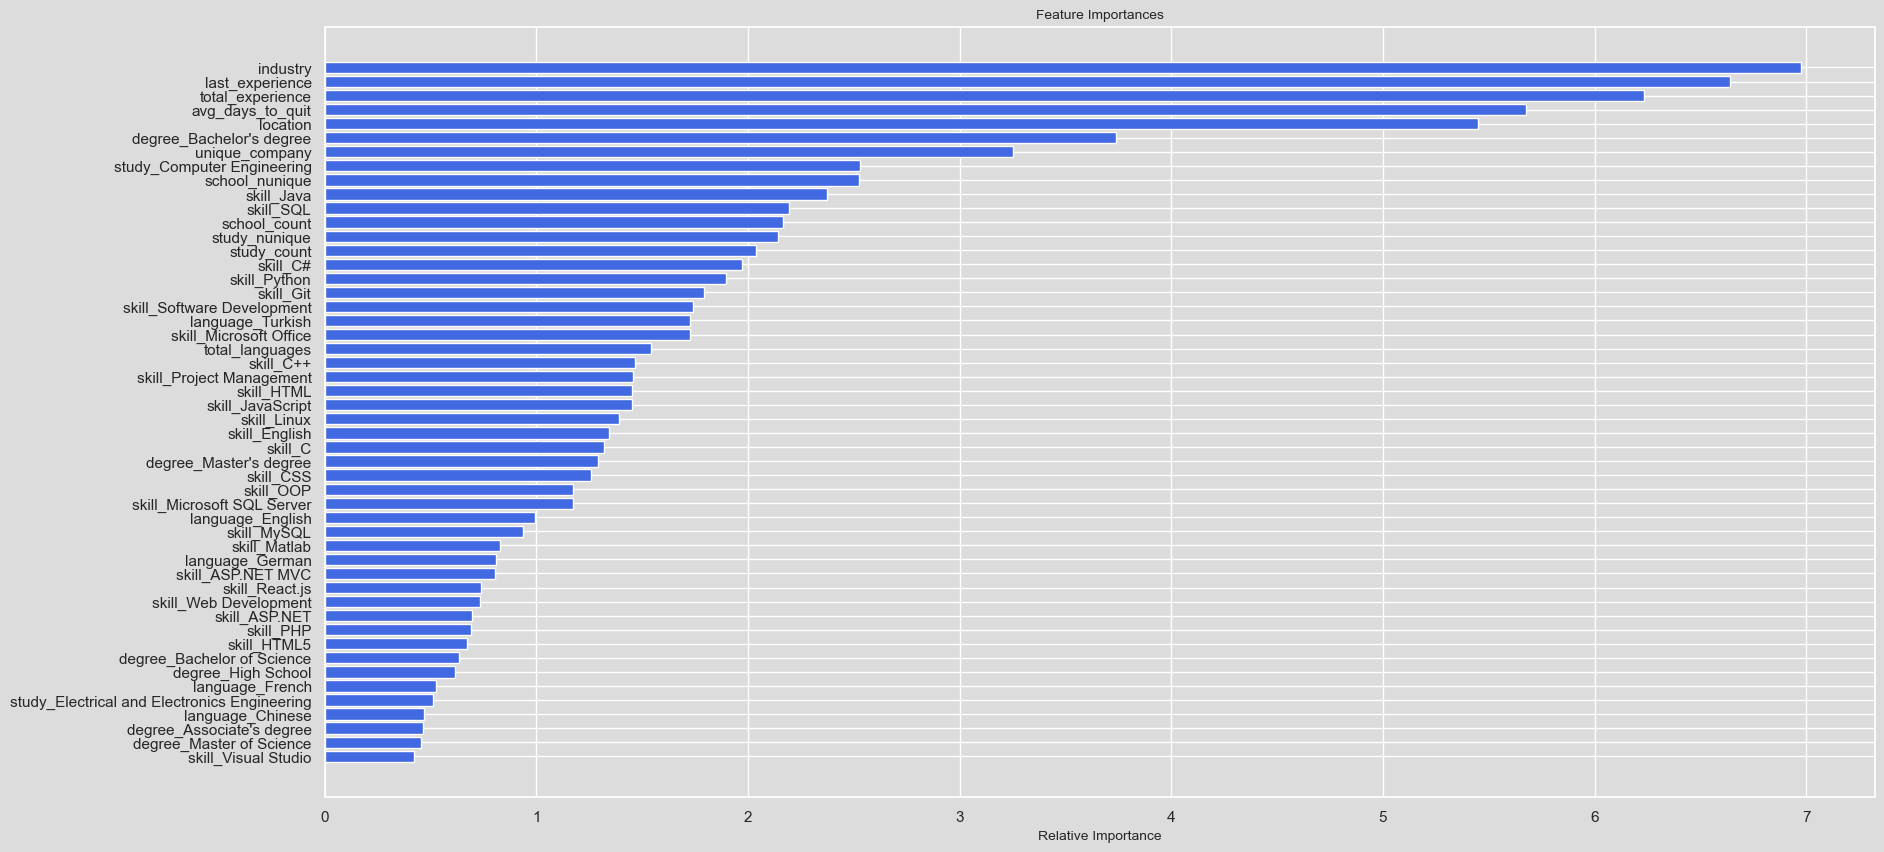

fold accuracy: 0.7633544590312359
accuracy: 0.7698372281634885


In [89]:
for idx, (train_ind, val_ind) in enumerate(kf.split(X, y)):
    print(f"| Fold {idx+1} |".center(80, "-"))
    model = CatBoostClassifier(**params)
    #model = XGBClassifier(**params)
    X_train = X.iloc[train_ind]
    y_train = y.iloc[train_ind]
    X_val = X.iloc[val_ind]
    y_val = y.iloc[val_ind]

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=400,
        verbose=200,
    )

    plot_importances(model, features)

    val_pred = model.predict(X_val)
    y_oof[val_ind] += val_pred

    test_pred = model.predict(X_test)
    y_pred += test_pred / config.n_folds

    print(f'fold accuracy: {accuracy_score(y_val, val_pred)}')
    del X_train, y_train, X_val, y_val
    gc.collect()

val_score = accuracy_score(y, y_oof)
print(f'accuracy: {val_score}')

In [92]:
sub[target] = np.where(y_pred >= 0.5, 1, 0).tolist()

sub.head()

,user_id,moved_after_2019
0,17449,0
1,33967,1
2,2110,0
3,55082,0
4,37165,0


In [93]:
sub.to_csv(f'../submissions/submission_{round(val_score, 6)}.csv', index = False)